<a href="https://colab.research.google.com/github/RoseBorges44/I2A2-ABDI/blob/main/I2A2_Classifica%C3%A7%C3%A3o_C%C3%A3es_e_Gatos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 <a href="https://www.i2ai.org/">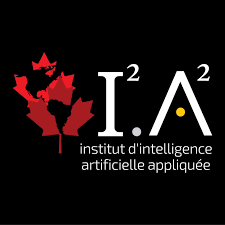 &nbsp;&nbsp;Projeto 5 - Classificação de Cães e Gatos com Visão Computacional


# Rosemeri Borges

#Importação das bibliotecas

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import zipfile
import numpy as np
import os  # Acesso a recursos do sistema operacional
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow
# Tensor Flow
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LSTM, MaxPool2D, Flatten, Dense,Dropout, GRU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import RMSprop
tf.__version__

'2.15.0'

#**Como Iniciar o Projeto?**

##**Passo 1:** Coloque os arquivos de imagem Zip em uma pasta qualquer no seu Google Drive
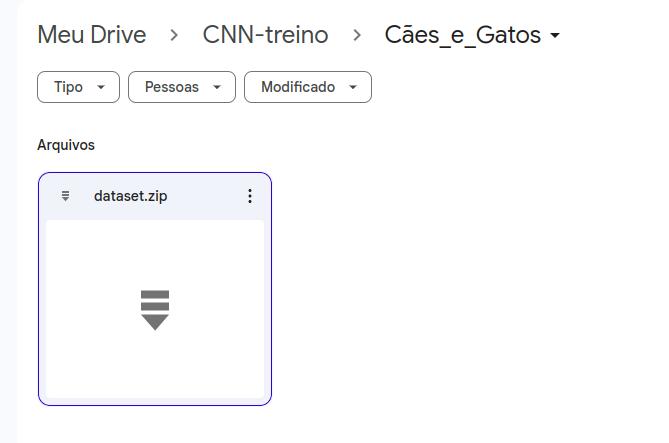

##**Passo2:** Descompactando da base de dados

O comando abaixo irá importar a função **drive** do módulo **google.colab** e, em seguida, monta o **Google Drive** no diretório **'/content/drive'**. Isso permite que você acesse e trabalhe com arquivos armazenados no seu Google Drive diretamente no ambiente do Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Lembrete Importante!**

**path = '/content/drive/MyDrive/CNN-treino/Cães_e_Gatos/dataset.zip'**: Define o caminho completo para o arquivo zip que você deseja extrair.
Para saber o caminho certo para o seu arquivo zip clique pasta localizada na lateral esquerda do colab:

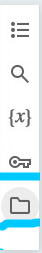

Clique em Drive >> MyDrive e procure o arquivo desejado:

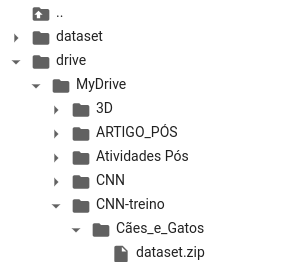

Clique nos três pontos ao lado do arquivo dataset.zip, com isso surgirá a opção copiar caminho. Clicando em copiar caminhoiremos obter o caminho exato do dataset:

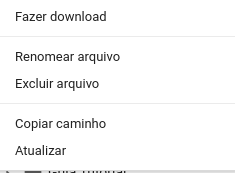

Em seguida, cole o caminho do arquivo em ***path***. O comando a seguir iŕa descompactar os arquivos presente no diretório ***path***, e carregar em uma pasta temporária do colab chamada ***content***.

In [ ]:
path = '/content/drive/MyDrive/CNN-treino/Cães_e_Gatos/dataset.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

**path = '/content/drive/MyDrive/CNN-treino/Cães_e_Gatos/dataset.zip'**: Define o caminho completo para o arquivo zip que você deseja extrair. No exemplo dado, o caminho aponta para um arquivo chamado 'dataset.zip' localizado no diretório **'/content/drive/MyDrive/CNN-treino/Cães_e_Gatos/'**.

**zip_object = zipfile.ZipFile(file=path, mode='r')**: Cria um objeto ZipFile utilizando a biblioteca zipfile. Esse objeto é usado para manipular arquivos zip. O parâmetro file recebe o caminho para o arquivo zip, e mode='r' indica que o arquivo será lido.

**zip_object.extractall('./')**: Extrai todo o conteúdo do arquivo zip para o diretório atual (indicado por ./). Isso significa que todos os arquivos e pastas presentes no arquivo zip serão descompactados no diretório em que o código está sendo executado.

**zip_object.close()**: Fecha o objeto ZipFile após a extração do conteúdo. É uma boa prática fechar o objeto após o uso para liberar recursos.

##**Passo3:** Visualizando imagens do dataset

Visualizando uma pequena parte das imagens de treino

In [ ]:
#Variável para armazenar os diretórios das pastas com as imagens
diretorio = '/content/dataset/training_set'
# "classe" -  Mostra possíveis "classes" para as imagens de acordo com a nomenclatura das pastas inclusas no diretório
classe = os.listdir(diretorio)
print(classe)

['dogs', 'cats']


In [ ]:
#"arquivos" - Gera uma lista que ordena os nomes das imagens
class_names=['dogs','cats']
arquivos = [[os.path.join(diretorio, class_name, x)
               for x in os.listdir(os.path.join(diretorio, class_name))] # Variável para armazenar as imagens em uma lista
               for class_name in class_names]

In [ ]:
image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(arquivos[i])
    image_label_list.extend([i] * len(arquivos[i]))
    num_total = len(image_label_list)

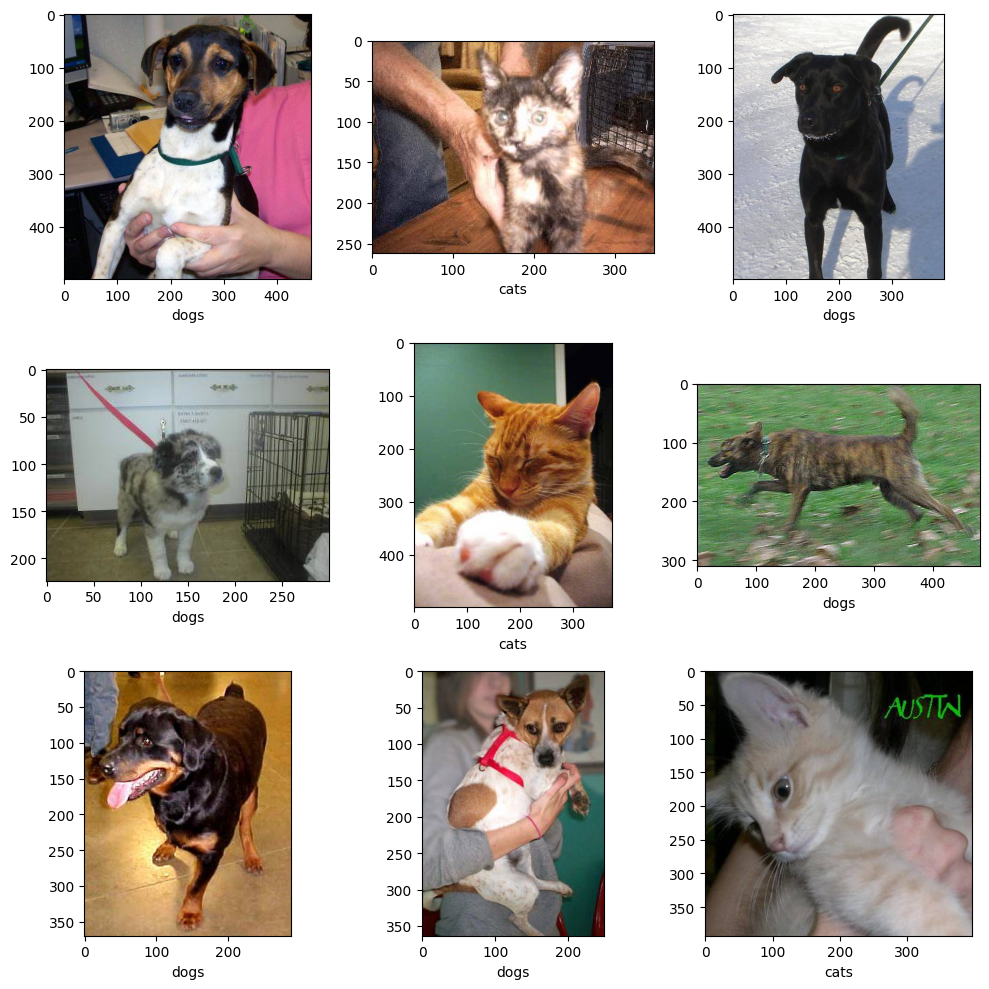

In [ ]:
plt.subplots(3,3, figsize=(10,10))
for i,k in enumerate(np.random.randint(num_total, size=9)):
    im = Image.open(image_file_list[k])
    arr = np.array(im)
    plt.subplot(3,3, i+1)
    plt.xlabel(class_names[image_label_list[k]])
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.tight_layout()
plt.show()

Com o gráfico acima podemos dizer que as imagens apresentam dimensões diferentes, sendo necessário aplicar um tratamento no conjunto de dados

#Construindo uma Rede Neural Convolucional (CNN)

##**Passo 1:** Normalização

A função **ImageDataGenerator** do Keras aplica diversos tratamentos nas imagens, normalização de pixels, rotação e zoom.

In [ ]:
treinamento = ImageDataGenerator(rescale=1./255,       # normaliza os pixels
                                         rotation_range=7,     # rotaciona a imagem em graus
                                         horizontal_flip=True, # rolações na horizontal
                                         zoom_range=0.2)       # Aplica zoom

A função a seguir cria um dataset baseado no conteúdo de um determinado diretório, redimensiona as imagens, cria batchs, e possibilita a definição de shuffle para tornar a ordem de leitura das imagens aleatórias.

##**Passo 2:** Separar em Train/Test

**Train**

In [ ]:
# Cria um dataset buscando todas a imagens em um determiando diretório
# A mensagem após a execução dessa linha irá indicar a quantidade de imagens, e a quantidade de classes, no caso, ele identifica de acordo com a quantidade de pastas no diretório
dataset_treinamento = treinamento.flow_from_directory('/content/dataset/training_set', # diretório
                                                              target_size = (64, 64), # dimensões das imagens
                                                              batch_size = 8,         # batch das imagens - lotes de 8
                                                              class_mode = 'categorical',
                                                              shuffle = True) # Mistura as imagens antes de mandar para a rede neural

Found 7996 images belonging to 2 classes.


Temos um total de 7996 imagens, separadas em 2 classes. A separação automática de classes ocorre por termos duas pastas no diretório.

In [ ]:
dataset_treinamento.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

Novamente, a separação e o nome das classe ocorrem por conta do nome atribuido as pastas no diretório especificado

In [ ]:
dataset_treinamento.class_indices

{'cats': 0, 'dogs': 1}

Com o gráfico a seguir, conseguimos visualizar que a distribuição dos dados está equilibrada, tendo a mesma quantidade de imagens para cães e gatos

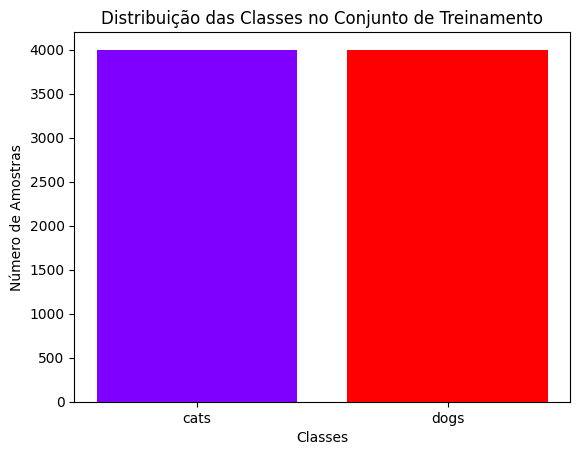

In [ ]:
# Obtém a contagem de amostras em cada classe usando np.unique
_, class_counts = np.unique(dataset_treinamento.classes, return_counts=True)

# Obtém a lista de rótulos de classe
class_labels = list(dataset_treinamento.class_indices.keys())

# Gera cores diferentes para cada classe
colors = plt.cm.rainbow(np.linspace(0, 1, len(class_labels)))

# Cria o gráfico de barras com cores diferentes
plt.bar(class_labels, class_counts, color=colors)
plt.xlabel('Classes')
plt.ylabel('Número de Amostras')
plt.title('Distribuição das Classes no Conjunto de Treinamento')
plt.show()

**Teste**

In [ ]:
gerador_teste = ImageDataGenerator(rescale=1./255)
dataset_teste = gerador_teste.flow_from_directory('/content/dataset/test_set',
                                                  target_size = (64,64),
                                                  batch_size = 1,
                                                  class_mode = 'categorical',
                                                  shuffle=False)

Found 2000 images belonging to 2 classes.


Para os dados de teste utilizaremos um segundo dataset,a função será similar a anterior, trocando apena a quantidade de lotes em batch e o shuffle para false.

##**Passo 3**: Compreender o funcionamento de uma  rede neural

**Rede Neural**

Uma rede neural é um modelo computacional inspirado no sistema nervoso biológico, capaz de aprender e realizar tarefas através de um conjunto de conexões entre unidades de processamento chamadas de neurônios artificiais.

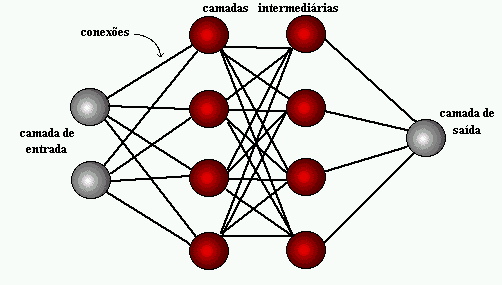

**Rede Neural Convolucional**

Uma Convolutional Neural Network (CNN) é um tipo de rede neural especializada em processamento de imagens, usando camadas convolucionais para extrair características e classificar padrões nas imagens.

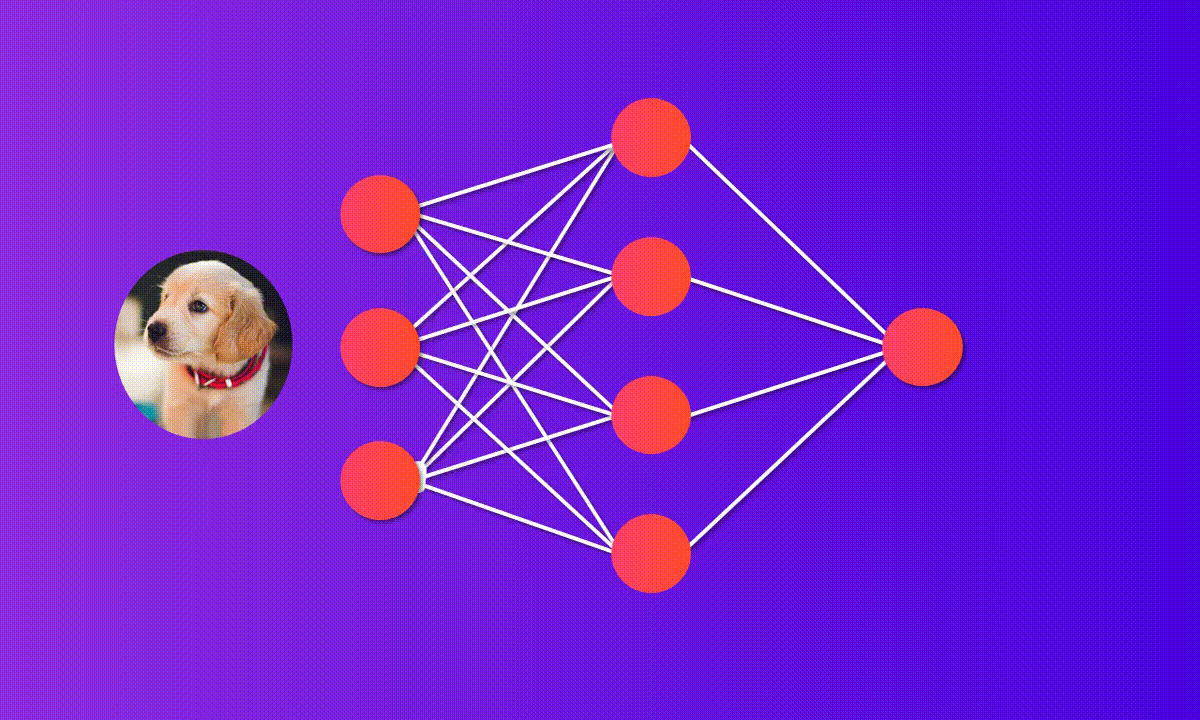

### Arquitetura de uma Rede Neural Convolucional

  **Operador Convolucional:** É o processo de adicionar cada elemento da imagem
para seus vizinhos, ponderado por um kernel/filtro. Em outras palavras é a combinação de duas fontes de informação, na tentativa de identificar padrões em imagens.


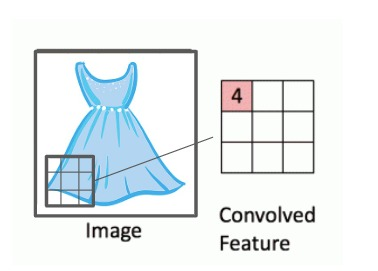

**Camada de Convolução**: É o conjunto de mapas de características, sendo a própria rede responsável por decidir qual detector de características será melhor para o modelo.

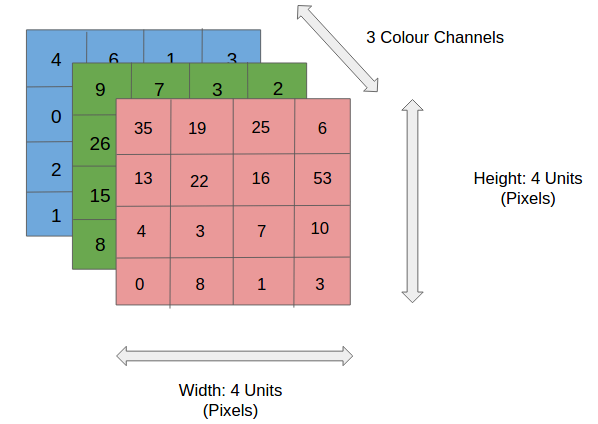

**Pooling**: Aplicado para enfatizar as características da imagem a ser classificada, sendo aplicado para reduzir a sensibilidade dos mapas de características, que poderão ser afetados por fatores externos da imagem.

Nesse filtro iremos selecionar os pontos com maior importância, reduzindo a quantidade de ruídos e possíveis overfits.





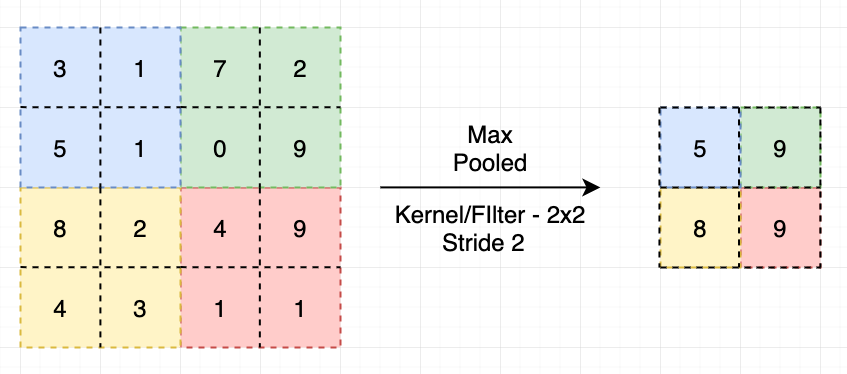

**Dropout**: função para a regularização de redes neurais, onde alguns neurônios são removidos com a finalidade de evitar um overfitting.

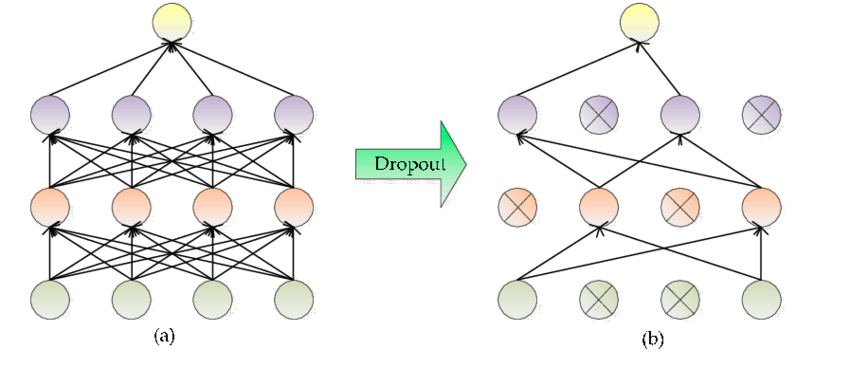

**Flattening**: função de achatamento, é aplicada para transformar a matriz de uma imagem em um vetor. Tal vetor será aplicado a camâda de entrada da rede neural.

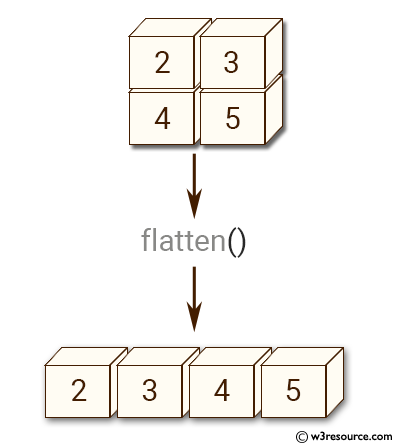

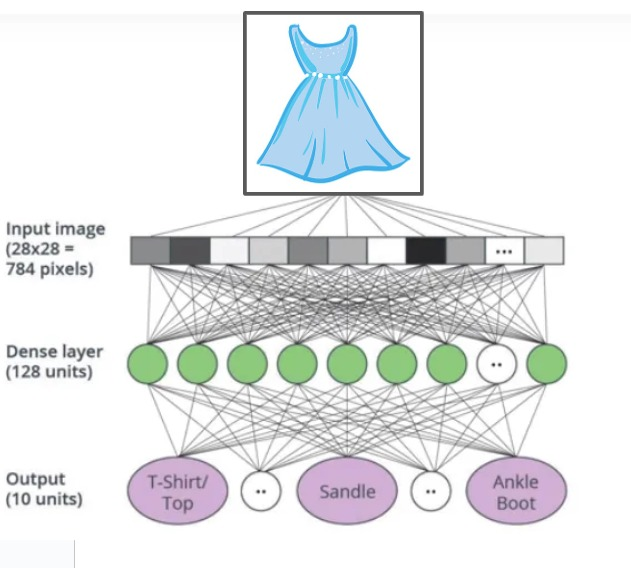

##**Passo4:** Construindo o Modelo

**Neurônios na camada de entrada**

A quantidade de neurônios na camada de entrada será igual a quantidade de pixels em uma imagem.

No caso, redimensinamos o nosso conjunto de dados para 64x64 (target_size)

In [ ]:
64*64

4096

Normalmente esse valor é aplicado automaticamento no comando Flatten

**Neurônios camada oculta**

O número de neurônios na camada oculta normalmente é definido de forma empírica, algumas fontes recomendam ao menos adotar um valor menor que o dobro do valor utilizado na camada de entrada, assim podemos evitar problemas como os de overffiting.

Autores como **Jeff Heaton**, de ***Introduction to Neural Networks for Java***, sugere as seguintes abordagens:

**1ª:** nº de neurônios na entrada + número de classes /  número de classes


In [ ]:
(4096+2)/2

2049.0

ou

**2ª** 2/3 do tamanho da camada de entrada

In [ ]:

(4096*2)/(3+2)

1638.4

NO caso, optamos por adotar a 1ª abordagem, 2049 neurônios na camada oculta.

**Construindo a arquitetura de rede neural convolucional (CNN) usando o framework Keras**

In [ ]:
# Sequential() - Cria um modelo sequencial, que é uma pilha linear de camadas.
network_cnn = Sequential()

# Primeira camada de convolução : Adiciona uma camada de convolução 2D com 32 filtros, cada um com tamanho de 3x3.
# A função de ativação é 'leaky_relu', e a entrada tem o formato (64, 64, 3) representando imagens de 64x64 pixels com 3 canais de cor (RGB).
network_cnn.add(Conv2D(filters=32, kernel_size=(3,3), activation='leaky_relu', input_shape=(64,64,3)))

# Camada de agrupamento máximo, máscara: Adiciona uma camada de agrupamento máximo (max pooling) com uma janela de pool de tamanho 2x2.
network_cnn.add(MaxPool2D(pool_size=(2,2)))

# Segunda camada de convolução : Adiciona uma segunda camada de convolução 2D com 64 filtros, cada um com tamanho de 3x3. A função de ativação é 'leaky_relu'.
network_cnn.add(Conv2D(filters=64, kernel_size=(3,3), activation='leaky_relu'))

# Camada de agrupamento máximo: Adiciona outra camada de agrupamento máximo.
network_cnn.add(MaxPool2D(pool_size=(2,2)))

# Terceira camada de convolução: Adiciona uma terceira camada de convolução 2D com 128 filtros, cada um com tamanho de 3x3. A função de ativação é 'leaky_relu'.
network_cnn.add(Conv2D(filters=128, kernel_size=(3,3), activation='leaky_relu'))

# Quarta camada de convolução
network_cnn.add(Conv2D(filters=256, kernel_size=(3,3), activation='leaky_relu'))

# Camada de agrupamento máximo
network_cnn.add(MaxPool2D(pool_size=(2,2)))

# Convertendo de uma matriz para um vetor - cada um dos valores presentes no vetor serão aplicados na entrada de uma rede neural densa
network_cnn.add(Flatten())

# Adiciona uma camada densa com 2049 neurônios e função de ativação 'relu'.
network_cnn.add(Dense(units = 2049, activation='relu'))

#Adiciona a camada de saída com 2 neurônios (correspondentes às classes) e função de ativação 'softmax', que gera uma distribuição de probabilidade sobre as classes.
network_cnn.add(Dense(units = 2, activation='softmax'))

network_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 256)      

In [ ]:
# Compila a arquitetura da rede neural, especificando o otimizador, a função de perda (loss), e as métricas a serem monitoradas durante o treinamento.
network_cnn.compile(optimizer = RMSprop(learning_rate = 0.001), loss='binary_crossentropy', metrics=['accuracy'])

**optimizer=RMSprop(learning_rate=0.001)**: Define o otimizador a ser utilizado durante o treinamento da rede neural. No caso, estamos utilizando o RMSprop. O RMSprop é um otimizador adaptativo que ajusta automaticamente a taxa de aprendizado para cada parâmetro com base na média acumulada dos gradientes passados. A taxa de aprendizado é controlada pelo parâmetro learning_rate, que é configurado como **0.001** neste exemplo.

**loss='binary_crossentropy'**: Especifica a função de perda a ser minimizada durante o treinamento. A entropia cruzada binária é uma escolha comum para problemas de classificação binária.

**metrics=['accuracy']**: Define as métricas a serem monitoradas durante o treinamento e avaliação do modelo. Neste caso, a métrica escolhida é 'accuracy' (acurácia), que mede a taxa de acertos da classificação.



In [ ]:
#Treinamento da rede neural, epochs=50 define a quantidade de iterações que será realizada no treinamento
historico_cnn = network_cnn.fit(dataset_treinamento, epochs=50)

Epoch 1/50
1000/1000 [==============================] - 28s 27ms/step - loss: 0.6819 - accuracy: 0.5798
Epoch 2/50
1000/1000 [==============================] - 27s 27ms/step - loss: 0.6188 - accuracy: 0.6736
Epoch 3/50
1000/1000 [==============================] - 27s 27ms/step - loss: 0.5828 - accuracy: 0.7002
Epoch 4/50
1000/1000 [==============================] - 27s 27ms/step - loss: 0.5533 - accuracy: 0.7389
Epoch 5/50
1000/1000 [==============================] - 27s 27ms/step - loss: 0.5294 - accuracy: 0.7437
Epoch 6/50
1000/1000 [==============================] - 28s 28ms/step - loss: 0.5111 - accuracy: 0.7603
Epoch 7/50
1000/1000 [==============================] - 27s 27ms/step - loss: 0.4950 - accuracy: 0.7744
Epoch 8/50
1000/1000 [==============================] - 27s 27ms/step - loss: 0.4943 - accuracy: 0.7785
Epoch 9/50
1000/1000 [==============================] - 27s 27ms/step - loss: 0.4777 - accuracy: 0.7819
Epoch 10/50
1000/1000 [==============================] - 27s 27m

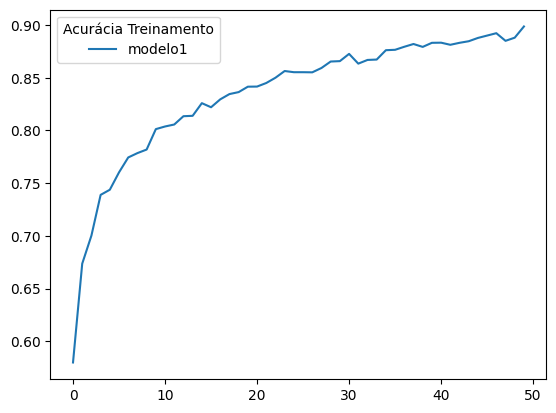

In [ ]:
plt.plot(historico_cnn.history['accuracy']);

plt.legend(labels=['modelo1'], title = "Acurácia Treinamento");

#**Como Avaliar os resultados Obtidos?**

In [ ]:
# Mostra as classes pertencentes ao dataset
dataset_teste.class_indices

{'cats': 0, 'dogs': 1}

In [ ]:
previsores2 = network_cnn.predict(dataset_teste)
#previsores2

2000/2000 [==============================] - 6s 3ms/step


In [ ]:
# Transformamos os resultados de previsores3 em uma array com resultados binários
previsores2 = np.argmax(previsores2, axis = 1)
previsores2

array([1, 1, 0, ..., 0, 1, 1])

In [ ]:
# Visualizamos os resultados dos dados de teste
dataset_teste.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(dataset_teste.classes, previsores2)

0.8735

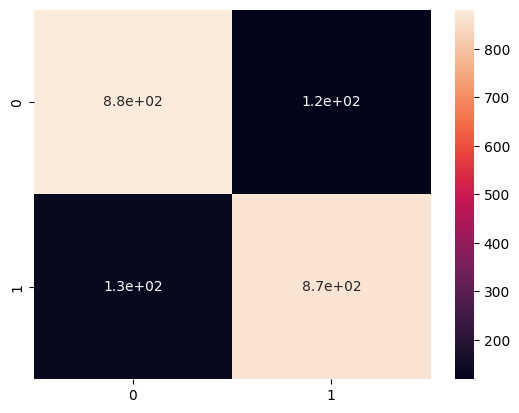

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(dataset_teste.classes, previsores2)
sns.heatmap(cm, annot=True);

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(dataset_teste.classes, previsores2))

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      1000
           1       0.88      0.87      0.87      1000

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000



**Justificativa:**


Os resultados são equilibrados, com **precisão**, **recall** e **F1-score** em torno de **83%** para ambas as classes.
<br/>
<br/>
A alta precisão indica que o modelo não está classificando erroneamente muitas instâncias como positivas.
<br/>
<br/>
O recall também é bastante equilibrado, mostrando que o modelo está capturando a maioria das instâncias positivas.
<br/>
<br/>
A acurácia global de 83% é uma indicação geral de desempenho positivo do modelo.
<br/>
<br/>
Em resumo, os resultados indicam um bom desempenho geral do modelo na tarefa de classificação binária.




